# Fermipy tutorial

This tutorial shows how to perform Fermi-LAT analysis with the Fermipy Python package. 
Many parts of this tutorial are taken directly from the documentation page of Fermipy: [fermipy.readthedocs](http://fermipy.readthedocs.io/en/latest/).
I suggest to visit the documentation page to find further informations.

Fermipy is a python package created by Mattew Wood and maintained by a wide community of people. Fermipy facilitates analysis of data from the Large Area Telescope (LAT) with the Fermi Science Tools.
The Fermipy package is built on the pyLikelihood interface of the Fermi Science Tools and provides a set of high-level tools for performing common analysis tasks:
* Data and model preparation with the gt-tools (gtselect, gtmktime, etc.).
* Extracting a spectral energy distribution (SED) of a source.
* Generating TS and residual maps for a region of interest.
* Finding new source candidates.
* Localizing a source or fitting its spatial extension.
* Perfoming phase analysis
* Calculating light curves
* Deriving the sensitivity of gamma-ray sources with a specific SED and spatial morphology.

# Installation

Instruction on how to install in SLAC machines or in your laptop Fermipy are available at this page: [fermipy.installation](http://fermipy.readthedocs.io/en/latest/install.html).
Fermipy is only compatible with Science Tools v10r0p5 or later. If you are using an earlier version, you will need to download and install the latest version from the [FSSC](https://fermi.gsfc.nasa.gov/ssc/). Note that it is recommended to use the non-ROOT binary distributions of the Science Tools. These instructions assume that you want to run Fermipy on the SLAC machines.

With these instructions you will create your own Conda installation and you will install all the packages needed to use FermiPy and Science Tools.
Using your own Conda installation avoids conflicts with package versions because you build your own environment.

First grab the installation and setup scripts from the fermipy github repository:

In [ ]:
! curl -OL https://raw.githubusercontent.com/fermiPy/fermipy/master/condainstall.sh
! curl -OL https://raw.githubusercontent.com/fermiPy/fermipy/master/slacsetup.sh

Now choose an installation path. This should be a new directory (e.g. $HOME/anaconda) that has at least 2-4 GB available. We will assign this location to the CONDABASE environment variable which is used by the setup script to find the location of your python installation. To avoid setting this every time you log in it's recommended to set CONDABASE into your .bashrc file.

Now run the following commands to install anaconda and fermipy. This will take about 5-10 minutes.

In [ ]:
! export CONDABASE=<path to install directory>
! bash condainstall.sh $CONDABASE

Once anaconda is installed you will initialize your python and ST environment by running the slacsetup function in slacsetup.sh. This function will set the appropriate environment variables needed to run the STs and python.

In [ ]:
! source slacsetup.sh
! slacsetup

For convenience you can also copy this function into your .bashrc file so that it will automatically be available when you launch a new shell session. By default the function will setup your environment to point to a recent version of the STs and the installation of python in CONDABASE. If CONDABASE is not defined then it will use the installation of python that is packaged with a given release of the STs. The slacsetup function takes two optional arguments which can be used to override the ST version or python installation path.

In [ ]:
# Use ST 10-00-05
! slacsetup 10-00-05
# Use ST 11-01-01 and python distribution located at <PATH>
! slacsetup 11-01-01 <PATH>

The installation script only installs packages that are required by fermipy and the STs. Once you've initialized your shell environment you are free to install additional python packages with the conda package manager tool with conda install <package name>. Packages that are not available on conda can also be installed with pip.

conda install fermipy

conda can also be used to upgrade packages. For instance you can upgrade fermipy to the newest version with the conda update command:

In [ ]:
! conda update fermipy

If you want to make development of Fermipy you should get the github version making:

In [ ]:
! git clone https://github.com/fermiPy/fermipy.git

Then you should create a branch using:

In [ ]:
! git checkout -b mattia-dev

In the branch you can make your development of Fermipy and then use the git commands to merge them to the master repository.

More informations on how to install Fermipy are available here: [fermipy-install](http://fermipy.readthedocs.io/en/latest/install.html)

# Configuration file:

The first step is to compose a configuration file that defines the data selection and analysis parameters. Fermipy uses YAML files to read and write its configuration in a persistent format. The configuration file has a hierarchical structure that groups parameters into dictionaries that are keyed to a section name (data, binning, etc.). Below I report a sample of configuration applied for an analysis of the SMC:

In [2]:
%matplotlib inline

import os
import numpy as np
from fermipy.gtanalysis import GTAnalysis
from fermipy.plotting import ROIPlotter, SEDPlotter
import matplotlib.pyplot as plt
import matplotlib

ImportError: No module named fermipy.gtanalysis

In [3]:
if os.path.isfile('../data/SMC_data.tar.gz'):
    !tar xzf ../data/SMC_data.tar.gz
else:
    !curl -OL https://raw.githubusercontent.com/fermiPy/fermipy-extras/master/data/SMC_data.tar.gz
    !tar xzf SMC_data.tar.gz

In [5]:
cat config.yaml

data:
  evfile : 'ft1.fits'
  scfile : '/u/gl/mdimauro/kipac/workdir/files/SC/P8_104months_ft2.fits'
  ltcube : '/u/gl/mdimauro/dmcat/workdir/mattia/LogNLogS_Ebins/files_bins/bin13/P8_SOURCE_zmax105_1_3_ltcube.fits'

binning:
  roiwidth   : 12.0
  binsz      : 0.08
  binsperdec : 8
  coordsys   : 'GAL'

selection :
  emin : 1000
  emax : 500000
  tmin : 239557417
  tmax : 512994417
  zmax    : 105
  evclass : 128
  evtype  : 3
  glon: 302.25
  glat : -44.37
 
gtlike:
  edisp : True
  irfs : 'P8R2_SOURCE_V6'
  edisp_disable : ['isodiff','galdiff']

model:
  src_roiwidth : 12.0
  galdiff  : '$FERMI_DIFFUSE_DIR/gll_iem_v06.fits'
  isodiff  : '$FERMI_DIFFUSE_DIR/iso_P8R2_SOURCE_V6_v06.txt'  
  catalogs: gll_psc_v16.fit

fileio:
  usescratch: False


The configuration file has the same structure as the configuration dictionary such that one can read/write configurations using the load/dump methods of the yaml module:

In [ ]:
import yaml
# Load a configuration
config = yaml.load(open('config.yaml'), Loader=yaml.FullLoader)
# Update a parameter and write a new configuration
config['selection']['emin'] = 1000.
yaml.dump(config, open('new_config.yaml','w'))

The data section defines the input data set and spacecraft file for the analysis. Here evfile points to a list of FT1 files that encompass the chosen ROI, energy range, and time selection.
The parameters in the binning section define the dimensions of the ROI and the spatial and energy bin size.
The selection section defines parameters related to the data selection (energy range, zmax cut, and event class/type). The target parameter in this section defines the ROI center to have the same coordinates as the given source.
The model section defines parameters related to the ROI model definition (diffuse templates, point sources).
Fermipy gives the user the option to combine multiple data selections into a joint likelihood with the components section. For more informations on this visit: http://fermipy.readthedocs.io/en/latest/quickstart.html

Note that the setup for a joint analysis is identical to the above except for the modification to the components section.  The following example shows the components configuration one would use to define a joint analysis with the four PSF event types:
```python
components:
  - { selection : { evtype : 4  } }
  - { selection : { evtype : 8  } }
  - { selection : { evtype : 16 } }
  - { selection : { evtype : 32 } }
```

# Start your run

First of all you need to load the configuration file, create the object gta and run the tool gta.setup that implements the ST gtselect, gtmktime, gtbin, gtexpcube, gtsrcmap tools

In [1]:
%matplotlib inline

import os
import numpy as np
from fermipy.gtanalysis import GTAnalysis
from fermipy.plotting import ROIPlotter, SEDPlotter
import matplotlib.pyplot as plt
import matplotlib

In [3]:
if os.path.isfile('../data/SMC_data.tar.gz'):
    !tar xzf ../data/SMC_data.tar.gz
else:
    !curl -OL https://raw.githubusercontent.com/fermiPy/fermipy-extras/master/data/SMC_data.tar.gz
    !tar xzf SMC_data.tar.gz

In [4]:
gta = GTAnalysis('new_config.yaml')
matplotlib.interactive(True)
gta.setup()

2018-06-29 17:10:10 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 0.17.2+9.gacd6.dirty 
ScienceTools version ScienceTools-11-07-00
2018-06-29 17:10:12 INFO    GTAnalysis.setup(): Running setup.
2018-06-29 17:10:12 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2018-06-29 17:10:12 INFO    GTBinnedAnalysis.run_gtapp(): Running gtselect.
2018-06-29 17:10:12 INFO    GTBinnedAnalysis.run_gtapp(): time -p gtselect infile=ft1.fits outfile=/nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/ft1_00.fits ra=14.5034619337 dec=-72.7495444282 rad=8.98528137424 tmin=239557417.0 tmax=512994417.0 emin=1000.0 emax=500000.0 zmin=0.0 zmax=105.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=3 clobber=yes debug=no gui=no mode="ql"
2018-06-29 17:10:13 INFO    GTBinnedAnalysis.run_gtapp(): This is gtselect version ScienceTools-11-07-00
2018-06-29 17:10:13 INFO

2018-06-29 17:13:57 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 3FGL J0021.6-6835
2018-06-29 17:13:57 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 3FGL J2351.9-7601
2018-06-29 17:13:57 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 3FGL J2338.7-7401
2018-06-29 17:13:57 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 3FGL J0146.4-6746
2018-06-29 17:13:57 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 3FGL J2336.5-7620
2018-06-29 17:13:57 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 3FGL J0002.0-6722
2018-06-29 17:13:57 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named isodiff
2018-06-29 17:13:57 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named galdiff
2018-06-29 17:13:57 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 3FGL J0002.0-6722....................!
2018-06-29 17:13:57 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 3FGL J0021.6-6835..............

In [5]:
gta.print_model()

2018-06-29 17:14:28 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
3FGL J0059.0-7242e     0.088   1.059  1.45e-05   2.22       nan      1434.2     
3FGL J0112.9-7506      2.572   1.172  1.31e-06   2.17       nan       120.0     
3FGL J0023.9-7203      2.662   0.714   9.3e-06   2.65       nan      1675.8     
3FGL J0029.1-7045      3.008   0.506  2.49e-06   2.28       nan       269.9     
3FGL J0021.6-6835      5.122   1.859  5.27e-07   2.65       nan        84.0     
3FGL J2351.9-7601      5.495   1.027  3.74e-06   1.69       nan       117.5     
3FGL J2338.7-7401      5.777   0.677  4.38e-06   1.89       nan       213.2     
3FGL J0146.4-6746      6.423   0.420  1.03e-06   2.39       nan       123.7     
3FGL J2336.5-7620      6.454   0.557  1.66e-06   2.33       nan       186.9     
3FGL J0002.0-6722      7.153   0.483  2.07e-06   1.95 

In [7]:
gta.free_sources()
gta.fit()

2018-06-29 17:14:49 INFO    GTAnalysis.fit(): Starting fit.
/u/gl/mdimauro/kipac/software/anaconda/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:226: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2018-06-29 17:15:05 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2018-06-29 17:15:05 INFO    GTAnalysis.fit(): LogLike:   -77797.480 DeltaLogLike:       77.991 


{'config': {'covar': True,
  'init_lambda': 0.0001,
  'max_iter': 100,
  'min_fit_quality': 2,
  'optimizer': 'MINUIT',
  'reoptimize': False,
  'retries': 3,
  'tol': 0.001,
  'verbosity': 0},
 'correlation': array([[ 1.00000000e+00,  4.41213321e-01, -1.68928666e-03,
         -1.26101446e-03,  4.75069270e-03,  2.99355059e-03,
         -2.27977805e-03,  4.30742411e-03,  1.80080622e-03,
          1.19095108e-02,  2.64517667e-03,  3.98596710e-03,
          2.18620628e-03,  6.03607400e-03,  2.94792882e-03,
          4.92794564e-03,  2.93347538e-03,  4.75911932e-03,
          2.74784090e-03,  2.74212616e-03,  2.85560646e-03,
         -1.20322982e-02, -2.65882496e-02, -3.31780055e-02],
        [ 4.41213321e-01,  1.00000000e+00, -1.73755585e-03,
         -7.26334318e-04,  3.04604145e-03,  1.77554687e-03,
         -1.02995968e-03,  2.64139475e-03,  1.82329601e-03,
          1.15173698e-02,  8.09669776e-03,  3.05839750e-03,
          2.39391524e-03,  3.42156860e-03,  2.30245155e-03,
          

# Output files

The current state of the ROI can be written at any point by calling write_roi.

In [7]:
gta.write_roi('initial',make_plots=True,save_model_map=True)

2018-03-13 08:49:12 INFO    GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/initial_00.xml...
2018-03-13 08:49:12 INFO    GTAnalysis.write_fits(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/initial.fits...
2018-03-13 08:49:13 INFO    GTBinnedAnalysis.write_model_map(): Generating model map for component 00.
2018-03-13 08:49:15 INFO    GTAnalysis.write_roi(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/initial.npy...


The output file will contain all information about the state of the ROI as calculated up to that point in the analysis including model parameters and measured source characteristics (flux, TS, NPred). An XML model file will also be saved for each analysis component.

The output file can be read with load:

In [8]:
gta.load_roi('initial')

2018-03-13 08:50:57 INFO    GTAnalysis.load_roi(): Loading ROI file: /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/initial.npy
2018-03-13 08:50:58 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2018-03-13 08:51:16 INFO    GTAnalysis.load_roi(): Finished Loading ROI


Using gta.print_model You have an overview of the sources and components present in the ROI.

In [9]:
gta.print_model()

2018-03-13 08:51:26 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
3FGL J0059.0-7242e     0.088   1.059  1.45e-05   2.22       nan      1434.2     
3FGL J0112.9-7506      2.572   1.172  1.31e-06   2.17       nan       120.0     
3FGL J0023.9-7203      2.662   0.714   9.3e-06   2.65       nan      1675.8     
3FGL J0029.1-7045      3.008   0.506  2.49e-06   2.28       nan       269.9     
3FGL J0021.6-6835      5.122   1.859  5.27e-07   2.65       nan        84.0     
3FGL J2351.9-7601      5.495   1.027  3.74e-06   1.69       nan       117.5     
3FGL J2338.7-7401      5.777   0.677  4.38e-06   1.89       nan       213.2     
3FGL J0146.4-6746      6.423   0.420  1.03e-06   2.39       nan       123.7     
3FGL J2336.5-7620      6.454   0.557  1.66e-06   2.33       nan       186.9     
3FGL J0002.0-6722      7.153   0.483  2.07e-06   1.95 

# Source Dictionary

The sources dictionary contains one element per source keyed to the source name. It is possible to have access to a lot of informations concerning each source of model.

In [10]:
print gta.roi.sources[0].name #NAME OF THE SOURCE
print gta.roi[gta.roi.sources[0].name] #NAME OF THE SOURCE
print gta.roi[gta.roi.sources[0].name]['glon'] #Longitude OF THE SOURCE
print gta.roi[gta.roi.sources[0].name]['glat'] #Latitude OF THE SOURCE
print gta.roi[gta.roi.sources[0].name]['flux'] #Flux OF THE SOURCE
print gta.roi[gta.roi.sources[0].name]['npred'] #npred OF THE SOURCE

3FGL J0059.0-7242e
Name           : 3FGL J0059.0-7242e
Associations   : ['3FGL J0059.0-7242e', 'SMC', '2FGL J0059.0-7242e']
RA/DEC         :     14.750/   -72.700
GLON/GLAT      :    302.145/   -44.417
TS             : nan
Npred          : 1434.19
Flux           : 3.508e-09 +/-      nan
EnergyFlux     : 1.447e-05 +/-      nan
SpatialModel   : SpatialMap
SpectrumType   : PowerLaw
Spectral Parameters
Prefactor      :  1.059e-11 +/-        nan
Index          :     -2.221 +/-        nan
Scale          :      665.5 +/-        nan
302.1449479051668
-44.41669737470087
3.50766230419e-09
1434.19374951


Other possible outputs are listed here [fermipy/sourcedictionary](http://fermipy.readthedocs.io/en/latest/output.html)

In [8]:
gta.free_shape(gta.roi.sources[0].name,free=False) #Free or fix the index
gta.get_free_source_params(gta.roi.sources[0].name) #Free or fix parameters for a source
gta.set_parameter(gta.roi.sources[0].name,par='Index',value=2.0,scale=-1.0,bounds=[-2.,5.]) #Change the value and bounds for a parameter of a source

You can always use gta.print_model() to have a summary of you model.

In [9]:
gta.print_model()

2018-03-12 01:02:47 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
3FGL J0059.0-7242e     0.088   1.059  3.75e+05  -2.00       nan550368946660.2     
3FGL J0112.9-7506      2.572   1.172  1.31e-06   2.17       nan       120.0     
3FGL J0023.9-7203      2.662   0.714   9.3e-06   2.65       nan      1675.8     
3FGL J0029.1-7045      3.008   0.506  2.49e-06   2.28       nan       269.9     
3FGL J0021.6-6835      5.122   1.859  5.27e-07   2.65       nan        84.0     
3FGL J2351.9-7601      5.495   1.027  3.74e-06   1.69       nan       117.5     
3FGL J2338.7-7401      5.777   0.677  4.38e-06   1.89       nan       213.2     
3FGL J0146.4-6746      6.423   0.420  1.03e-06   2.39       nan       123.7     
3FGL J2336.5-7620      6.454   0.557  1.66e-06   2.33       nan       186.9     
3FGL J0002.0-6722      7.153   0.483  2.07e-06   1.9

# Customizing your model

The ROIModel class is responsible for managing the source and diffuse components in the ROI. Configuration of the model is controlled with the model block of YAML configuration file.

DIFFUSE AND ISOTROPIC TEMPLATES

The simplest configuration uses a single file for the galactic and isotropic diffuse components. By default the galactic diffuse and isotropic components will be named galdiff and isodiff respectively. An alias for each component will also be created with the name of the mapcube or file spectrum. For instance the galactic diffuse can be referred to as galdiff or gll_iem_v06 in the following example.

To define two or more galactic diffuse components you can optionally define the galdiff and isodiff parameters as lists. A separate component will be generated for each element in the list with the name galdiffXX or isodiffXX where XX is an integer position in the list.

SOURCE COMPONENT

The list of sources for inclusion in the ROI model is set by defining a list of catalogs with the catalogs parameter. Catalog files can be in either XML or FITS format. Sources from the catalogs in this list that satisfy either the src_roiwidth or src_radius selections are added to the ROI model. If a source is defined in multiple catalogs the source definition from the last file in the catalogs list takes precedence.

Individual sources can also be defined within the configuration file with the sources parameter. This parameter contains a list of dictionaries that defines the spatial and spectral parameters of each source. The keys of the source dictionary map to the spectral and spatial source properties as they would be defined in the XML model file.

Or you can do it while you are running your script with:

In [11]:
gta.delete_source(gta.roi.sources[0].name)
glon0 = gta.config['selection']['glon']
glat0 = gta.config['selection']['glat']
gta.add_source('SMC', dict(glon=glon0, glat=glat0, Index=dict(value=-2.4,scale=1.0,max="-1.",min="-5."), Scale=dict(value=1e3,scale=1.0,max="1e5",min="1e0"), Prefactor=dict(value=1.0,scale=1e-13,max="10000.0", min="0.0001"), SpectrumType='PowerLaw'), free=True, init_source=True, save_source_maps=True)
gta.print_model()

2018-03-13 08:54:18 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J0059.0-7242e
2018-03-13 08:54:18 INFO    GTAnalysis.add_source(): Adding source SMC
2018-03-13 08:54:21 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
SMC                    0.000   1.000  2.29e-07   2.40       nan        29.1    *
3FGL J0112.9-7506      2.572   1.172  1.31e-06   2.17       nan       120.0     
3FGL J0023.9-7203      2.662   0.714   9.3e-06   2.65       nan      1675.8     
3FGL J0029.1-7045      3.008   0.506  2.49e-06   2.28       nan       269.9     
3FGL J0021.6-6835      5.122   1.859  5.27e-07   2.65       nan        84.0     
3FGL J2351.9-7601      5.495   1.027  3.74e-06   1.69       nan       117.5     
3FGL J2338.7-7401      5.777   0.677  4.38e-06   1.89       nan       213.2     
3FGL J0146.4-6746      6.423   0.420  1.03e-06   2.39 

All sources have nan because we have not done yet a fit do the ROI. Moreover in the model above all sources are fixed. In order to free the parameters of the source it's enough to make gta.free_sources()

In [12]:
gta.free_sources()
gta.print_model()

2018-03-13 08:55:29 INFO    GTAnalysis.free_source(): Freeing parameters for SMC                   : ['Index']
2018-03-13 08:55:29 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0112.9-7506     : ['Prefactor', 'Index']
2018-03-13 08:55:29 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0023.9-7203     : ['norm', 'alpha', 'beta']
2018-03-13 08:55:29 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0029.1-7045     : ['Prefactor', 'Index']
2018-03-13 08:55:29 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0021.6-6835     : ['Prefactor', 'Index']
2018-03-13 08:55:29 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J2351.9-7601     : ['Prefactor', 'Index']
2018-03-13 08:55:29 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J2338.7-7401     : ['Prefactor', 'Index']
2018-03-13 08:55:29 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0146.4-6746     : ['Prefactor', 'Index']
2018-03-13 08:55:2

It is also possible to free only the sources that are at a certain angular distance from a source. For example below we free the sources that are 2 degrees away from 3FGL J0322.5-3721:

In [13]:
gta.free_sources(free=False)
gta.free_sources(skydir=gta.roi[gta.roi.sources[0].name].skydir,distance=[3.0],free=True)
gta.print_model()

2018-03-13 08:55:53 INFO    GTAnalysis.free_source(): Fixing parameters for SMC                   : ['Prefactor', 'Index']
2018-03-13 08:55:53 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0112.9-7506     : ['Prefactor', 'Index']
2018-03-13 08:55:53 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0023.9-7203     : ['norm', 'alpha', 'beta']
2018-03-13 08:55:53 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0029.1-7045     : ['Prefactor', 'Index']
2018-03-13 08:55:53 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0021.6-6835     : ['Prefactor', 'Index']
2018-03-13 08:55:53 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J2351.9-7601     : ['Prefactor', 'Index']
2018-03-13 08:55:53 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J2338.7-7401     : ['Prefactor', 'Index']
2018-03-13 08:55:53 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0146.4-6746     : ['Prefactor', 'Index']
2018-03-13 08

# Fit Roi

Source fitting with fermipy is generally performed with the optimize and fit methods.
fit is a wrapper on the pyLikelihood fit method and performs a likelihood fit of all free parameters of the model. This method can be used to manually optimize of the model by calling it after freeing one or more source parameters.

In [14]:
gta.print_model()
gta.free_sources(free=True)
gta.print_model()
first_fit=gta.fit()
gta.print_model()
gta.write_roi('SMC_firstfit',make_plots=True,save_model_map=True)

2018-03-13 08:57:33 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
SMC                    0.000   1.000  2.29e-07   2.40       nan        29.1    *
3FGL J0112.9-7506      2.572   1.172  1.31e-06   2.17       nan       120.0    *
3FGL J0023.9-7203      2.662   0.714   9.3e-06   2.65       nan      1675.8    *
3FGL J0029.1-7045      3.008   0.506  2.49e-06   2.28       nan       269.9     
3FGL J0021.6-6835      5.122   1.859  5.27e-07   2.65       nan        84.0     
3FGL J2351.9-7601      5.495   1.027  3.74e-06   1.69       nan       117.5     
3FGL J2338.7-7401      5.777   0.677  4.38e-06   1.89       nan       213.2     
3FGL J0146.4-6746      6.423   0.420  1.03e-06   2.39       nan       123.7     
3FGL J2336.5-7620      6.454   0.557  1.66e-06   2.33       nan       186.9     
3FGL J0002.0-6722      7.153   0.483  2.07e-06   1.95 

By default fit will repeat the fit until a fit quality of 3 is obtained. After the fit returns all sources with free parameters will have their properties (flux, TS, NPred, etc.) updated in the ROIModel instance. The return value of the method is a dictionary containing the following diagnostic information about the fit.

The fit also accepts keyword arguments which can be used to configure its behavior at runtime:

In [15]:
print first_fit['fit_quality']
print first_fit['errors']
print first_fit['loglike']
print first_fit['values']

3
[0.06897512 0.14098837 1.32411177 0.62478644 0.05717115 0.18539581
 0.07944857 0.05971143 0.11155104 0.21146844 0.11248447 0.0826967
 0.12099797 0.08760999 0.15519491 0.0615716  0.09687903 0.1599308
 0.10136505 2.49923201 0.1704357  0.02041181 0.02279252 0.04930773]
-78035.9995577
[ 3.60516850e-01  1.91219709e+00  1.73806768e+00  3.24769612e+00
  6.27231469e-01  1.24052645e+00  5.64444940e-01  4.78933136e-01
  2.36532680e+00  1.31093846e+00  2.01633654e+00  4.85554010e-01
  2.24771696e+00  4.02307719e-01  2.31324995e+00  5.44326655e-01
  1.98899192e+00  1.37263734e+00  2.01250792e+00  2.06230598e+01
 -3.15999065e+00  9.72002812e-01 -1.24469681e-02  1.00754268e+00]


In [16]:
print gta.roi.sources[0]['param_names']
print gta.roi.sources[0]['param_values']
print gta.roi.sources[0]['param_errors']

['Prefactor' 'Index' 'Scale' '' '' '' '' '' '' '']
[ 2.06230598e-12 -3.15999065e+00  1.00000000e+03             nan
             nan             nan             nan             nan
             nan             nan]
[2.49923201e-13 1.70435698e-01            nan            nan
            nan            nan            nan            nan
            nan            nan]


The optimize method performs an automatic optimization of the ROI by fitting all sources with an iterative strategy. It is generally good practice to run this method once at the start of your analysis to ensure that all parameters are close to their global likelihood maxima.

In [17]:
gta.load_roi('initial')
gta.print_model()

2018-03-13 09:00:15 INFO    GTAnalysis.load_roi(): Loading ROI file: /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/initial.npy
2018-03-13 09:00:15 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2018-03-13 09:00:33 INFO    GTAnalysis.load_roi(): Finished Loading ROI
2018-03-13 09:00:33 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
3FGL J0059.0-7242e     0.088   1.059  1.45e-05   2.22       nan      1434.2     
3FGL J0112.9-7506      2.572   1.172  1.31e-06   2.17       nan       120.0     
3FGL J0023.9-7203      2.662   0.714   9.3e-06   2.65       nan      1675.8     
3FGL J0029.1-7045      3.008   0.506  2.49e-06   2.28       nan       269.9     
3FGL J0021.6-6835      5.122   1.859  5.27e-07   2.65       nan        84.0     
3FGL J2351.9-7601      5.495   1.027  3.74e-06 

In [18]:
gta.load_roi('SMC_firstfit')
gta.print_model()

2018-03-13 09:00:47 INFO    GTAnalysis.load_roi(): Loading ROI file: /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/SMC_firstfit.npy
2018-03-13 09:00:47 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2018-03-13 09:01:05 INFO    GTAnalysis.load_roi(): Finished Loading ROI
2018-03-13 09:01:05 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
SMC                    0.000  20.623  1.78e-06   3.16    276.72       384.7    *
3FGL J0112.9-7506      2.572   1.311   2.1e-06   2.02    152.25       144.0    *
3FGL J0023.9-7203      2.662   0.627  9.93e-06   2.72   5150.54      1829.1    *
3FGL J0029.1-7045      3.008   0.479  2.02e-06   2.37    259.37       244.4    *
3FGL J0021.6-6835      5.122   1.738   1.8e-07   3.25      7.93        39.4    *
3FGL J2351.9-7601      5.495   1.373  2.78

# TS Map

tsmap() generates a test statistic (TS) map for an additional source component centered at each spatial bin in the ROI. The methodology is similar to that of the gttsmap ST application but with the following approximations:

* Evaluation of the likelihood is limited to pixels in the vicinity of the test source position.
* The background model is fixed when fitting the test source amplitude.

TS Cube is a related method that can also be used to generate TS maps as well as cubes (TS vs. position and energy).

In [19]:
tsmap_postfit = gta.tsmap(prefix='TSmap_start',make_plots=True,write_fits=True,write_npy=True)

2018-03-13 09:02:00 INFO    GTAnalysis.tsmap(): Generating TS map
2018-03-13 09:02:02 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2018-03-13 09:02:26 INFO    GTAnalysis.tsmap(): Finished TS map
2018-03-13 09:02:26 INFO    GTAnalysis.tsmap(): Execution time: 26.63 s


Text(0.5,1,u'NPred')

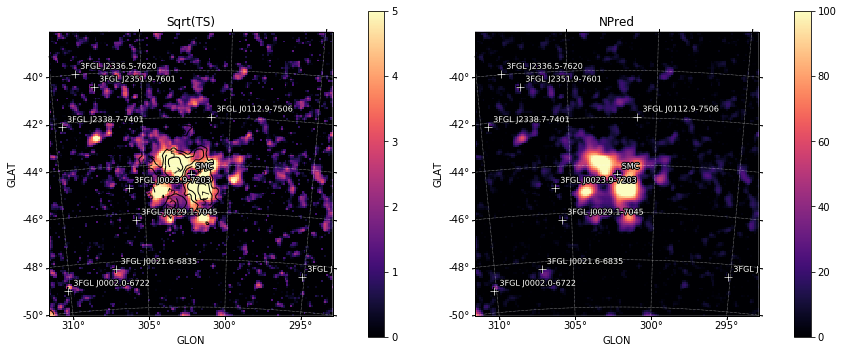

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(14,6))
ROIPlotter(tsmap_postfit['sqrt_ts'],roi=gta.roi).plot(levels=[0,3,5,7],vmin=0,vmax=5,subplot=121,cmap='magma')
plt.gca().set_title('Sqrt(TS)')
ROIPlotter(tsmap_postfit['npred'],roi=gta.roi).plot(vmin=0,vmax=100,subplot=122,cmap='magma')
plt.gca().set_title('NPred')

Looking to the TSmap it is quite clear that the model does not fit sufficiently well the data.

# Residual Map

residmap() calculates the residual between smoothed data and model maps. Whereas a TS map is only sensitive to positive deviations with respect to the model, residmap() is sensitive to both positive and negative residuals and therefore can be useful for assessing the model goodness-of-fit. 

2018-03-13 09:05:01 INFO    GTAnalysis.residmap(): Generating residual maps
2018-03-13 09:05:01 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2018-03-13 09:05:04 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2018-03-13 09:05:08 INFO    GTAnalysis.residmap(): Finished residual maps
2018-03-13 09:05:08 INFO    GTAnalysis.residmap(): Execution time: 7.04 s


Text(0.5,1,u'Excess')

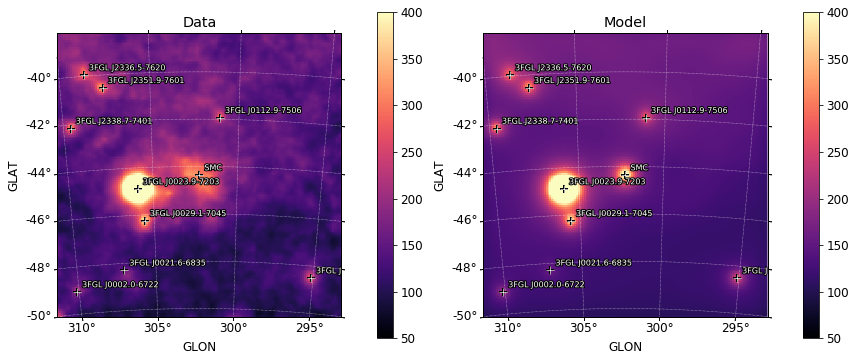

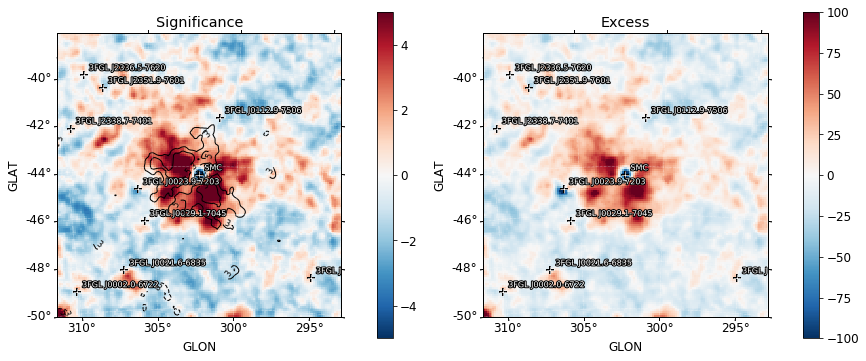

In [21]:
resid = gta.residmap('SMC_postfit',model={'SpatialModel' : 'PointSource', 'Index' : 2.0},write_fits=True,write_npy=True,make_plots=True)
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['data'],roi=gta.roi).plot(vmin=50,vmax=400,subplot=121,cmap='magma')
plt.gca().set_title('Data')
ROIPlotter(resid['model'],roi=gta.roi).plot(vmin=50,vmax=400,subplot=122,cmap='magma')
plt.gca().set_title('Model')

fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['sigma'],roi=gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121,cmap='RdBu_r')
plt.gca().set_title('Significance')
ROIPlotter(resid['excess'],roi=gta.roi).plot(vmin=-100,vmax=100,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess')

# Source Localization

The localize() method can be used to spatially localize a source. Localization is performed by scanning the likelihood surface in source position in a local patch around the nominal source position. The fit to the source position proceeds in two iterations:

TS Map Scan: Obtain a first estimate of the source position by generating a likelihood map of the region using the tsmap method. In this step all background parameters are fixed to their nominal values. The size of the search region used for this step is set with the dtheta_max parameter.
Likelihood Scan: Refine the position of the source by performing a scan of the likelihood surface in a box centered on the best-fit position found in the first iteration. The size of the search region is set to encompass the 99% positional uncertainty contour. This method uses a full likelihood fit at each point in the likelihood scan and will re-fit all free parameters of the model.
If a peak is found in the search region and the positional fit succeeds, the method will update the position of the source in the model to the new best-fit position.

In [22]:
gta.free_sources(free=False)
gta.print_model()
gta.free_sources(skydir=gta.roi[gta.roi.sources[0].name].skydir,distance=[3.0],free=True)
gta.print_model()
localsmc = gta.localize(gta.roi.sources[0].name, update=True, make_plots=True)
gta.print_model()

2018-03-13 09:06:52 INFO    GTAnalysis.free_source(): Fixing parameters for SMC                   : ['Prefactor', 'Index']
2018-03-13 09:06:52 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0112.9-7506     : ['Prefactor', 'Index']
2018-03-13 09:06:52 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0023.9-7203     : ['norm', 'alpha', 'beta']
2018-03-13 09:06:52 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0029.1-7045     : ['Prefactor', 'Index']
2018-03-13 09:06:52 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0021.6-6835     : ['Prefactor', 'Index']
2018-03-13 09:06:52 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J2351.9-7601     : ['Prefactor', 'Index']
2018-03-13 09:06:52 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J2338.7-7401     : ['Prefactor', 'Index']
2018-03-13 09:06:52 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0146.4-6746     : ['Prefactor', 'Index']
2018-03-13 09

The SMC is relocalized at 0.07deg.

In [23]:
print localsmc['glon']
print localsmc['glat']
print localsmc['pos_r68']
print localsmc['pos_r95']
print localsmc['pos_r99']
print localsmc['pos_err_semimajor']
print localsmc['pos_err_semiminor']
print localsmc['dloglike_loc']

302.268226533
-44.4524360596
0.08528579471406204
0.13763414643974695
0.17066426620183411
0.09458478815924073
0.03343522651941691
3.25905231918


# Extension Fitting

The extension() method executes a source extension analysis for a given source by computing a likelihood ratio test with respect to the no-extension (point-source) hypothesis and a best-fit model for extension. The best-fit extension is found by performing a likelihood profile scan over the source width (68% containment) and fitting for the extension that maximizes the model likelihood. Currently this method supports two models for extension: a 2D Gaussian (RadialGaussian) or a 2D disk (RadialDisk).

By default the method will fix all background parameters before performing the extension fit. One can leave background parameters free by setting free_background=True.

In [24]:
gta.free_sources(free=False)
gta.print_model()
gta.free_sources(skydir=gta.roi[gta.roi.sources[0].name].skydir,distance=[3.0],free=True)
gta.print_model()
extensionsmc = gta.extension(gta.roi.sources[0].name,update=True,make_plots=True,sqrt_ts_threshold=3.0,spatial_model='RadialGaussian')
gta.print_model()

2018-03-13 09:10:34 INFO    GTAnalysis.free_source(): Fixing parameters for SMC                   : ['Prefactor', 'Index']
2018-03-13 09:10:34 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0112.9-7506     : ['Prefactor', 'Index']
2018-03-13 09:10:34 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0023.9-7203     : ['norm', 'alpha', 'beta']
2018-03-13 09:10:34 INFO    GTAnalysis.free_source(): Fixing parameters for galdiff               : ['Prefactor', 'Index']
2018-03-13 09:10:34 INFO    GTAnalysis.free_source(): Fixing parameters for isodiff               : ['Normalization']
2018-03-13 09:10:34 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
SMC                    0.083  20.950  1.77e-06   3.18    288.19       386.8     
3FGL J0112.9-7506      2.572   1.311   2.1e-06   2.02    152.25       144.0     
3FGL J00

In this specific case SMC is found to be extended with TSext=371 and with an angular extension of 1.19\pm0.07deg.

In [25]:
print extensionsmc['ext']
print extensionsmc['ext_err_hi']
print extensionsmc['ext_err_lo']
print extensionsmc['ext_err']
print extensionsmc['ext']
print extensionsmc['ext_ul95']
print extensionsmc['ts_ext']

1.19481832399
0.06058810038300022
0.05922762264108816
0.05990786151204419
1.19481832399
1.2967768993
439.900505393


# Source Finding

find_sources() is an iterative source-finding algorithm that uses peak detection on a TS map to find new source candidates. The procedure for adding new sources at each iteration is as follows:

* Generate a TS map for the test source model defined with the model argument.
* Identify peaks with sqrt(TS) > sqrt_ts_threshold and an angular distance of at least min_separation from a higher amplitude peak in the map.
* Order the peaks by TS and add a source at each peak starting from the highest TS peak. Set the source position by fitting a 2D parabola to the log-likelihood surface around the peak maximum. After adding each source, re-fit its spectral parameters.
* Add sources at the N highest peaks up to N = sources_per_iter.

Source finding is repeated up to max_iter iterations or until no peaks are found in a given iteration. Sources found by the method are added to the model and given designations PS JXXXX.X+XXXX according to their position in celestial coordinates.

In [26]:
gta.free_sources()
model = {'Index' : 2.0, 'SpatialModel' : 'PointSource'}
findsource26 = gta.find_sources(model=model,sqrt_ts_threshold=5,min_separation=0.2,tsmap_fitter='tsmap')

2018-03-13 09:14:13 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0021.6-6835     : ['Prefactor', 'Index']
2018-03-13 09:14:13 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J2351.9-7601     : ['Prefactor', 'Index']
2018-03-13 09:14:13 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J2338.7-7401     : ['Prefactor', 'Index']
2018-03-13 09:14:13 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0146.4-6746     : ['Prefactor', 'Index']
2018-03-13 09:14:13 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J2336.5-7620     : ['Prefactor', 'Index']
2018-03-13 09:14:13 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0002.0-6722     : ['Prefactor', 'Index']
2018-03-13 09:14:13 INFO    GTAnalysis.find_sources(): Starting.
2018-03-13 09:14:13 INFO    GTAnalysis.tsmap(): Generating TS map
2018-03-13 09:14:36 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2018-03-13 09:14:57 INFO    GTAnalysis.tsmap(

2018-03-13 09:20:42 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
SMC                    0.083  47.942  9.77e-06   2.46    698.09      1331.1    *
PS J0040.7-7158        1.523   2.622   8.5e-07   2.24     48.32        86.4     
PS J0103.0-7052        1.912   3.520  4.88e-07   2.71     36.24        82.7     
PS J0046.3-7048        2.137   1.000   6.5e-07   1.99     27.36        41.6     
3FGL J0112.9-7506      2.572   1.322  2.14e-06   2.01    157.80       145.4    *
3FGL J0023.9-7203      2.662   0.602  9.81e-06   2.70   5132.30      1795.5    *
3FGL J0029.1-7045      3.008   0.477  2.05e-06   2.36    267.02       244.7    *
PS J0000.6-7353        4.263   2.136  8.28e-07   2.17     53.69        74.6     
3FGL J0021.6-6835      5.122   2.285   2.2e-07   3.30     11.97        49.0    *
3FGL J2351.9-7601      5.495   1.426  2.82e-06   2.03 

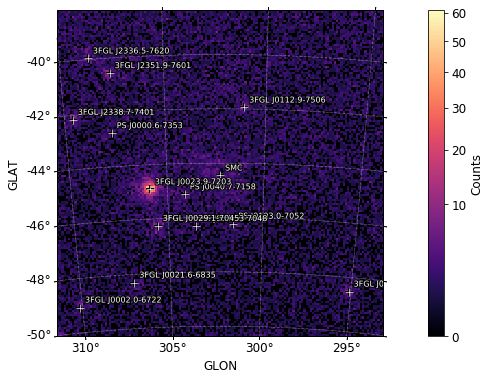

In [27]:
gta.print_model()
gta.write_roi('SMC_relext_TS25',make_plots=True,save_model_map=True)

In [28]:
tsmap_postfit = gta.tsmap(prefix='TSmap_relext_TS25',make_plots=True,write_fits=True,write_npy=True)

2018-03-13 09:21:16 INFO    GTAnalysis.tsmap(): Generating TS map
2018-03-13 09:21:43 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2018-03-13 09:22:09 INFO    GTAnalysis.tsmap(): Finished TS map
2018-03-13 09:22:13 INFO    GTAnalysis.tsmap(): Execution time: 56.80 s


Text(0.5,1,u'NPred')

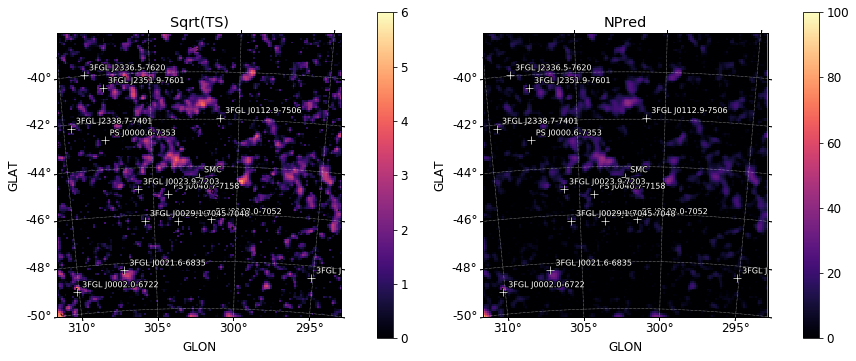

In [29]:
fig = plt.figure(figsize=(14,6))
ROIPlotter(tsmap_postfit['sqrt_ts'],roi=gta.roi).plot(levels=[0,3,5,7],vmin=0,vmax=6,subplot=121,cmap='magma')
plt.gca().set_title('Sqrt(TS)')
ROIPlotter(tsmap_postfit['npred'],roi=gta.roi).plot(vmin=0,vmax=100,subplot=122,cmap='magma')
plt.gca().set_title('NPred')

In [29]:
resid = gta.residmap('TSmap_relext_TS26',model={'SpatialModel' : 'PointSource', 'Index' : 2.0},write_fits=True,write_npy=True,make_plots=True)

2018-03-12 01:20:51 INFO    GTAnalysis.residmap(): Generating residual maps
2018-03-12 01:20:51 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2018-03-12 01:20:54 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2018-03-12 01:20:59 INFO    GTAnalysis.residmap(): Finished residual maps
2018-03-12 01:20:59 INFO    GTAnalysis.residmap(): Execution time: 7.56 s


Text(0.5,1,u'Excess')

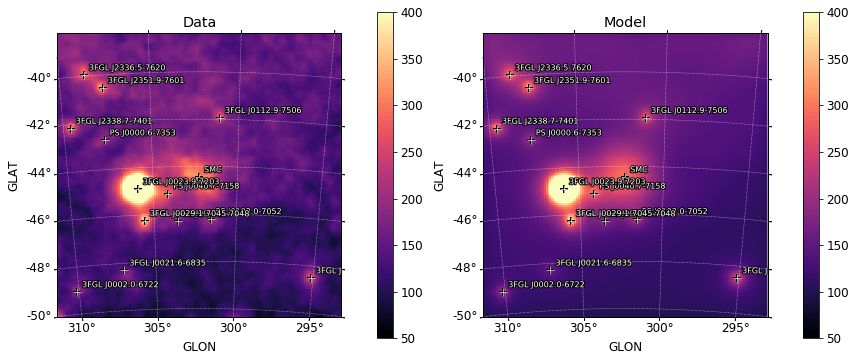

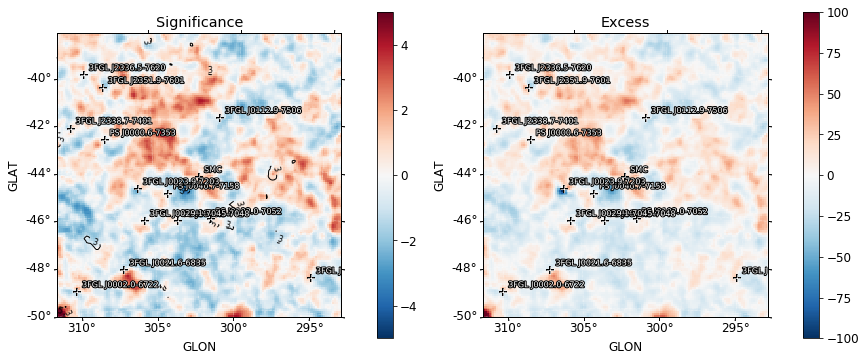

In [30]:
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['data'],roi=gta.roi).plot(vmin=50,vmax=400,subplot=121,cmap='magma')
plt.gca().set_title('Data')
ROIPlotter(resid['model'],roi=gta.roi).plot(vmin=50,vmax=400,subplot=122,cmap='magma')
plt.gca().set_title('Model')

fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['sigma'],roi=gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121,cmap='RdBu_r')
plt.gca().set_title('Significance')
ROIPlotter(resid['excess'],roi=gta.roi).plot(vmin=-100,vmax=100,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess')

# Sed Analysis

The sed() method computes a spectral energy distribution (SED) by performing independent fits for the flux normalization of a source in bins of energy. The normalization in each bin is fit using a power-law spectral parameterization with a fixed index. The value of this index can be set with the bin_index parameter or allowed to vary over the energy range according to the local slope of the global spectral model (with the use_local_index parameter).

The free_background, free_radius, and cov_scale parameters control how nuisance parameters are dealt with in the fit. By default the method will fix the parameters of background components ROI when fitting the source normalization in each energy bin (free_background=False). Setting free_background=True will profile the normalizations of all background components that were free when the method was executed. In order to minimize overfitting, background normalization parameters are constrained with priors taken from the global fit. The strength of the priors is controlled with the cov_scale parameter. A larger (smaller) value of cov_scale applies a weaker (stronger) constraint on the background amplitude. Setting cov_scale=None performs an unconstrained fit without priors.


In [30]:
gta.free_sources(free=False)
gta.print_model()
gta.free_sources(skydir=gta.roi[gta.roi.sources[0].name].skydir,distance=[3.0],free=True)
gta.print_model()
sedsmc = gta.sed(gta.roi.sources[0].name, bin_index=2.2, outfile='sedSMC.fits', loge_bins=None,write_npy=True,write_fits=True,make_plots=True)

2018-03-13 09:22:31 INFO    GTAnalysis.free_source(): Fixing parameters for SMC                   : ['Prefactor', 'Index']
2018-03-13 09:22:31 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0112.9-7506     : ['Prefactor', 'Index']
2018-03-13 09:22:31 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0023.9-7203     : ['norm', 'alpha', 'beta']
2018-03-13 09:22:31 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0029.1-7045     : ['Prefactor', 'Index']
2018-03-13 09:22:31 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0021.6-6835     : ['Prefactor', 'Index']
2018-03-13 09:22:31 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J2351.9-7601     : ['Prefactor', 'Index']
2018-03-13 09:22:31 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J2338.7-7401     : ['Prefactor', 'Index']
2018-03-13 09:22:31 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0146.4-6746     : ['Prefactor', 'Index']
2018-03-13 09

In [31]:
print sedsmc['e_min']
print sedsmc['e_max']
print sedsmc['e_ref']
print sedsmc['flux']
print sedsmc['eflux']
print sedsmc['e2dnde']
print sedsmc['dnde_ul95']
print sedsmc['ts']

[  1000.           1326.41675759   1759.38141482   2333.67299161
   3095.42296281   4105.8208897    5446.02963176   7223.70496591
   9581.64331867  12709.25226315  16857.76517829  22360.93710169
  29659.92168712  39341.41715463  52183.11498128  69216.55817447
  91810.00266538 121778.32604983 161528.81238386 214254.52357972
 284190.7904658  376955.42682685]
[  1326.41675759   1759.38141482   2333.67299161   3095.42296281
   4105.8208897    5446.02963176   7223.70496591   9581.64331867
  12709.25226315  16857.76517829  22360.93710169  29659.92168712
  39341.41715463  52183.11498128  69216.55817447  91810.00266538
 121778.32604983 161528.81238386 214254.52357972 284190.7904658
 376955.42682685 499999.99500797]
[  1151.70167908   1527.63640687   2026.28252958   2687.69510285
   3565.00382372   4728.68081266   6272.20147121   8319.5531384
  11035.19469844  14637.26717129  19415.33998741  25753.12880578
  34159.38160838  45309.5761943   60099.38114346  79716.82626953
 105737.73422587 140252.

[4.71409425e-06 4.85128874e-06 4.02094136e-06 3.77214791e-06
 3.20198520e-06 3.86513404e-06 3.49981956e-06 2.70842598e-06
 2.95706031e-06 3.34772891e-06 1.43144178e-06 2.57908864e-06
 6.49215943e-07 7.27163568e-07 2.14463923e-06 4.34605770e-06
 1.15856263e-06 5.49327998e-06 3.63567505e-06 2.70878298e-06
 4.45468680e-06 4.92143383e-06]


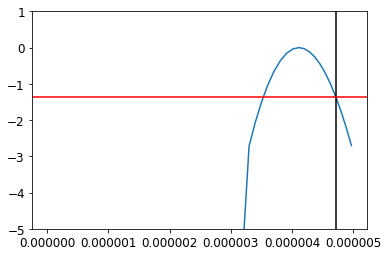

In [43]:
# E^2 x Differential flux ULs in each bin in units of MeV cm^{-2} s^{-1}
print sedsmc['e2dnde_ul95']

e2dnde_scan = sedsmc['norm_scan']*sedsmc['ref_e2dnde'][:,None]

plt.figure()
plt.plot(e2dnde_scan[0],sedsmc['dloglike_scan'][0]-np.max(sedsmc['dloglike_scan'][0]))
plt.gca().set_ylim(-5,1)
plt.gca().axvline(sedsmc['e2dnde_ul95'][0],color='k')
plt.gca().axhline(-2.71/2.,color='r')

(1e-07, 1e-05)

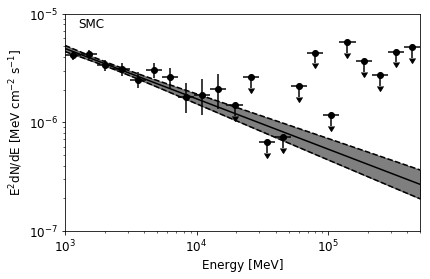

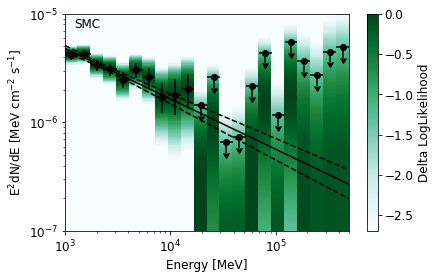

In [32]:
fig = plt.figure(figsize=(14,4))
ylim=[1E-7,1E-5]
fig.add_subplot(121)
SEDPlotter(sedsmc).plot()
plt.gca().set_ylim(ylim)

fig = plt.figure(figsize=(14,4))

fig.add_subplot(121)
SEDPlotter(sedsmc).plot(showlnl=True,ylim=ylim)
plt.gca().set_ylim(ylim)

# Light curve

lightcurve() fits the charateristics of a source (flux, TS, etc.) in a sequence of time bins. This method uses the data selection and model of a baseline analysis (e.g. the full mission) and is therefore restricted to analyzing time bins that are encompassed by the time selection of the baseline analysis. In general when using this method it is recommended to use a baseline time selection of at least several years or more to ensure the best characterization of background sources in the ROI.

When fitting a time bin the method will initialize the model to the current parameters of the baseline analysis. The parameters to be refit in each time bin may be controlled with free_background, free_sources, free_radius, free_params, and shape_ts_threshold options.

By default the lightcurve method will run an end-to-end analysis in each time bin using the same processing steps as the baseline analysis. Depending on the data selection and ROI size each time bin may take 10-15 minutes to process. There are several options which can be used to reduce the lightcurve computation time. The multithread option splits the analysis of time bins across multiple cores.

The use_scaled_srcmap option generates an approximate source map for each time bin by scaling the source map of the baseline analysis by the relative exposure.

In [38]:
lc = gta.lightcurve('SMC', free_radius=3.0, nbins=8, multithread=True, nthread=8, use_scaled_srcmap=True)

2018-03-06 09:59:28 INFO    GTAnalysis.lightcurve(): Computing Lightcurve for SMC
2018-03-06 09:59:31 INFO    lightcurve_273737042_307916667 GTAnalysis._process_lc_bin(): Fitting time range 273737042 307916667
2018-03-06 09:59:31 INFO    lightcurve_239557417_273737042 GTAnalysis._process_lc_bin(): Fitting time range 239557417 273737042
2018-03-06 09:59:31 INFO    lightcurve_307916667_342096292 GTAnalysis._process_lc_bin(): Fitting time range 307916667 342096292
2018-03-06 09:59:31 INFO    lightcurve_376275917_410455542 GTAnalysis._process_lc_bin(): Fitting time range 376275917 410455542
2018-03-06 09:59:32 INFO    lightcurve_410455542_444635167 GTAnalysis._process_lc_bin(): Fitting time range 410455542 444635167
2018-03-06 09:59:32 INFO    lightcurve_342096292_376275917 GTAnalysis._process_lc_bin(): Fitting time range 342096292 376275917
2018-03-06 09:59:32 INFO    lightcurve_444635167_478814792 GTAnalysis._process_lc_bin(): Fitting time range 444635167 478814792
2018-03-06 09:59:32 IN

Joint fit  ['3FGL J0023.9-7203', 'SMC', '3FGL J0029.1-7045']


2018-03-06 10:06:24 INFO    lightcurve_478814792_512994417 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_478814792_512994417/base_00.xml...


Joint fit  ['3FGL J0023.9-7203', 'SMC', '3FGL J0029.1-7045']
Fitting shape 3FGL J0023.9-7203 TS:    650.747
Fitting shape 3FGL J2338.7-7401 TS:    139.308
Fitting shape SMC TS:     97.090
Fitting shape 3FGL J2336.5-7620 TS:     35.448


2018-03-06 10:06:34 INFO    lightcurve_342096292_376275917 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_342096292_376275917/base_00.xml...


Joint fit  ['3FGL J0023.9-7203', 'SMC', '3FGL J0029.1-7045']
Fitting shape 3FGL J0029.1-7045 TS:     31.645
Fitting shape 3FGL J0146.4-6746 TS:     24.834
Fitting shape 3FGL J0112.9-7506 TS:     16.003
Fitting shape 3FGL J0023.9-7203 TS:    774.271
Fitting shape SMC TS:    107.830
Fitting shape 3FGL J0112.9-7506 TS:     55.524
Fitting shape 3FGL J2351.9-7601 TS:     36.849
Fitting shape 3FGL J2338.7-7401 TS:     24.165


2018-03-06 10:06:44 INFO    lightcurve_444635167_478814792 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_444635167_478814792/base_00.xml...


Fitting shape 3FGL J2336.5-7620 TS:     16.783
Joint fit  ['3FGL J0023.9-7203', 'SMC', '3FGL J0029.1-7045']
Fitting shape 3FGL J0023.9-7203 TS:    758.502


2018-03-06 10:06:47 INFO    lightcurve_410455542_444635167 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_410455542_444635167/base_00.xml...


Joint fit  ['3FGL J0023.9-7203', 'SMC', '3FGL J0029.1-7045']
Fitting shape 3FGL J0029.1-7045 TS:    121.157
Fitting shape SMC TS:     99.041


2018-03-06 10:06:48 INFO    lightcurve_376275917_410455542 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_376275917_410455542/base_00.xml...


Joint fit  ['3FGL J0023.9-7203', 'SMC', '3FGL J0029.1-7045']
Fitting shape 3FGL J2336.5-7620 TS:     24.979
Fitting shape 3FGL J0112.9-7506 TS:     22.872
Fitting shape 3FGL J2351.9-7601 TS:     21.466


2018-03-06 10:06:51 INFO    lightcurve_239557417_273737042 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_239557417_273737042/base_00.xml...
2018-03-06 10:06:51 INFO    lightcurve_307916667_342096292 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_307916667_342096292/fit_model_final_00.xml...


Joint fit  ['3FGL J0023.9-7203', 'SMC']
Fitting shape 3FGL J0146.4-6746 TS:     20.529
Fitting shape PS J0046.3-7048 TS:     16.553


2018-03-06 10:06:58 INFO    lightcurve_307916667_342096292 GTAnalysis._process_lc_bin(): Finished time range 307916667 342096292
2018-03-06 10:06:58 INFO    lightcurve_478814792_512994417 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_478814792_512994417/fit_model_final_00.xml...


Fitting shape 3FGL J0023.9-7203 TS:    709.094
Fitting shape SMC TS:    125.796
Fitting shape 3FGL J0023.9-7203 TS:    632.319
Fitting shape 3FGL J0023.9-7203 TS:    500.975
Fitting shape 3FGL J2351.9-7601 TS:     85.535
Fitting shape SMC TS:     88.057
Fitting shape SMC TS:     81.265
Fitting shape 3FGL J0146.4-6746 TS:     78.907
Fitting shape 3FGL J0029.1-7045 TS:     42.400
Fitting shape 3FGL J0146.4-6746 TS:     56.923
Fitting shape 3FGL J2338.7-7401 TS:     36.516
Fitting shape 3FGL J2338.7-7401 TS:     26.094
Fitting shape 3FGL J0029.1-7045 TS:     26.127
Fitting shape 3FGL J0002.0-6722 TS:     24.416


2018-03-06 10:07:05 INFO    lightcurve_478814792_512994417 GTAnalysis._process_lc_bin(): Finished time range 478814792 512994417


Fitting shape 3FGL J0023.9-7203 TS:    528.051


2018-03-06 10:07:06 INFO    lightcurve_273737042_307916667 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_273737042_307916667/base_00.xml...


Joint fit  ['3FGL J0023.9-7203', 'SMC', '3FGL J0029.1-7045']
Fitting shape SMC TS:     72.762
Fitting shape 3FGL J0029.1-7045 TS:     40.064
Fitting shape 3FGL J2351.9-7601 TS:     37.347


2018-03-06 10:07:08 INFO    lightcurve_342096292_376275917 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_342096292_376275917/fit_model_final_00.xml...


Fitting shape 3FGL J0002.0-6722 TS:     21.948
Fitting shape 3FGL J0112.9-7506 TS:     16.623


2018-03-06 10:07:13 INFO    lightcurve_342096292_376275917 GTAnalysis._process_lc_bin(): Finished time range 342096292 376275917
2018-03-06 10:07:14 INFO    lightcurve_376275917_410455542 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_376275917_410455542/fit_model_final_00.xml...


Fitting shape 3FGL J0023.9-7203 TS:    693.836


2018-03-06 10:07:15 INFO    lightcurve_410455542_444635167 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_410455542_444635167/fit_model_final_00.xml...


Fitting shape SMC TS:     85.350


2018-03-06 10:07:15 INFO    lightcurve_444635167_478814792 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_444635167_478814792/fit_model_final_00.xml...


Fitting shape 3FGL J2351.9-7601 TS:     46.093
Fitting shape 3FGL J2338.7-7401 TS:     25.605
Fitting shape 3FGL J0029.1-7045 TS:     25.038


2018-03-06 10:07:17 INFO    lightcurve_376275917_410455542 GTAnalysis._process_lc_bin(): Finished time range 376275917 410455542


Fitting shape 3FGL J0112.9-7506 TS:     20.364
Fitting shape PS J0103.0-7052 TS:     16.484


2018-03-06 10:07:18 INFO    lightcurve_410455542_444635167 GTAnalysis._process_lc_bin(): Finished time range 410455542 444635167
2018-03-06 10:07:19 INFO    lightcurve_444635167_478814792 GTAnalysis._process_lc_bin(): Finished time range 444635167 478814792
2018-03-06 10:07:19 INFO    lightcurve_239557417_273737042 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_239557417_273737042/fit_model_final_00.xml...
2018-03-06 10:07:21 INFO    lightcurve_273737042_307916667 GTBinnedAnalysis.write_xml(): Writing /nfs/slac/kipac/fs1/u/mdimauro/software/fermipy-extra/notebooks/lightcurve_273737042_307916667/fit_model_final_00.xml...
2018-03-06 10:07:21 INFO    lightcurve_239557417_273737042 GTAnalysis._process_lc_bin(): Finished time range 239557417 273737042
2018-03-06 10:07:22 INFO    lightcurve_273737042_307916667 GTAnalysis._process_lc_bin(): Finished time range 273737042 307916667
2018-03-06 10:07:22 INFO    GTAnalysis.lightcurv

In [39]:
print lc['tmin']
print lc['tmax']
print lc['fit_success']
print lc['ts_var']
print lc['flux']
print lc['eflux']
print lc['flux_ul95']

[2.39557417e+08 2.73737042e+08 3.07916667e+08 3.42096292e+08
 3.76275917e+08 4.10455542e+08 4.44635167e+08 4.78814792e+08]
[2.73737042e+08 3.07916667e+08 3.42096292e+08 3.76275917e+08
 4.10455542e+08 4.44635167e+08 4.78814792e+08 5.12994417e+08]
[ True  True  True  True  True  True  True  True]
6.30410086488123
[3.11593816e-09 2.91989027e-09 3.22673828e-09 3.31752155e-09
 3.08489595e-09 3.43246894e-09 3.72792397e-09 3.39914712e-09]
[9.54362626e-06 8.13657551e-06 8.53153333e-06 8.60202096e-06
 8.19314133e-06 1.34414438e-05 1.25737846e-05 1.13474413e-05]
[3.88218821e-09 3.58577700e-09 3.90047178e-09 4.01305347e-09
 3.77963292e-09 4.21589982e-09 4.42831291e-09 4.09962901e-09]


No handlers could be found for logger "matplotlib.legend"


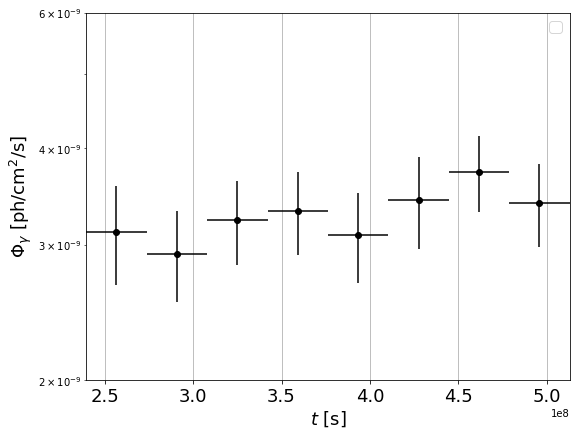

In [40]:
fig = plt.figure(figsize=(8,6))
plt.errorbar((lc['tmin']+lc['tmax'])/2., lc['flux'], yerr=lc['flux_err'], xerr=(lc['tmin']-lc['tmax'])/2., fmt="o", color="black")
plt.ylabel(r'$\Phi_{\gamma}$ [ph/cm$^2$/s]', fontsize=18)
plt.xlabel(r'$t$ [s]', fontsize=18)
plt.axis([lc['tmin'][0],lc['tmax'][len(lc['tmax'])-1],2e-9,6e-9], fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.yscale('log')
plt.xscale('linear')
plt.legend(loc=1,prop={'size':16},numpoints=1, scatterpoints=1, ncol=1)
fig.tight_layout(pad=0.5)
plt.show()